In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
from ranger import Ranger

In [4]:
path = Path('')

In [5]:
path.ls()

[PosixPath('__pycache__'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('Economic Data and 12 Month SP Return-Copy1.ipynb'),
 PosixPath('Market Model_12monthSP - Sheet1-Copy1.csv'),
 PosixPath('FOMC.ipynb'),
 PosixPath('data_lm_export.pkl'),
 PosixPath('fomcscrape4.csv'),
 PosixPath('models'),
 PosixPath('data_clas_export.pkl'),
 PosixPath('ranger.py')]

In [6]:
bs=16

In [7]:
df = pd.read_csv(path/'fomcscrape5.csv')
df.head()

,decision,text
0,hold,Chairman Alan Greenspan announced today that t...
1,hold,Chairman Alan Greenspan announced today that t...
2,raise,The Federal Reserve today announced two action...
3,hold,Chairman Alan Greenspan announced today that t...
4,raise,The Federal Reserve announced today the follow...


In [8]:
data_lm = TextLMDataBunch.from_csv(path, 'fomcscrape5.csv', max_vocab=60000, min_freq=2)

In [9]:
data_lm.vocab.itos[:5]

['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld']

In [10]:
data_lm.show_batch(3)

idx,text
0,"the rapid pace of productivity - xxunk gains in potential supply , xxunk continued pressure on resources . xxmaj the xxmaj committee is concerned that this xxunk in the growth of demand and potential supply will continue , which could foster inflationary imbalances that would undermine the economy 's xxunk performance . xxmaj against the background of its long - term goals of price stability and sustainable economic growth and"
1,"\n xxmaj last update : xxmaj december 9 , 2003 \n xxmaj the xxmaj committee perceives that the upside and downside risks to the attainment of sustainable growth for the next few quarters are roughly equal . xxmaj the probability of an unwelcome fall in inflation has diminished in recent months and now appears almost equal to that of a rise in inflation . xxmaj however , with"
2,"support to economic activity . xxmaj the evidence accumulated over the intermeeting period confirms that output is expanding briskly . xxmaj although new hiring remains subdued , other indicators suggest an improvement in the labor market . xxmaj increases in core consumer prices are muted and expected to remain low . \n xxmaj the xxmaj committee perceives that the upside and downside risks to the attainment of sustainable growth"


In [12]:
# Classifier DataBunch
data_clas = TextClasDataBunch.from_csv(path, 'fomcscrape5.csv', vocab=data_lm.train_ds.vocab, bs=8)

In [13]:
#Save both DataBunches
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

In [12]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                if N_sma > 5:                    
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

class PlainRAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                beta2_t = beta2 ** state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                if N_sma > 5:                    
                    step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    step_size = group['lr'] / (1 - beta1 ** state['step'])
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss


class AdamW(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, warmup = 0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad, use_variance=True, warmup = warmup)
        super(AdamW, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamW, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                if group['warmup'] > state['step']:
                    scheduled_lr = 1e-8 + state['step'] * group['lr'] / group['warmup']
                else:
                    scheduled_lr = group['lr']

                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * scheduled_lr, p_data_fp32)

                p_data_fp32.addcdiv_(-step_size, exp_avg, denom)

                p.data.copy_(p_data_fp32)

        return loss


In [14]:
optar = partial(Ranger)

In [15]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5) # wd=0.01 #opt_func=optar

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


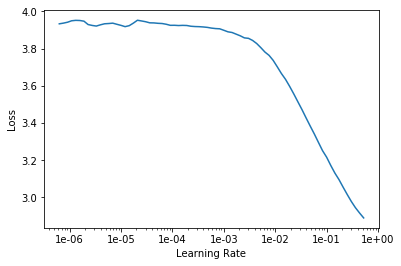

In [16]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [17]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.496324,1.724531,0.639425,00:04


In [18]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.309460,1.037646,0.775893,00:06
1,0.963529,0.967242,0.794364,00:06
2,0.685043,0.850858,0.825307,00:06
3,0.494955,0.881367,0.826088,00:06
4,0.370096,0.890833,0.829297,00:06
5,0.274523,0.861743,0.835910,00:06
6,0.210419,0.859539,0.840151,00:06
7,0.157431,0.839763,0.842913,00:06
8,0.124585,0.849387,0.842383,00:06
9,0.101327,0.843823,0.841713,00:06


In [19]:
learn.predict ("Given It's dual mandate", n_words=10)

"Given It's dual mandate , the Committee decided today to maintain the target"

In [20]:
learn.save_encoder('ft_enc')

### Classifier

In [21]:
bs=8

In [22]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5) #opt_func=RAdam or #opt_func=optar

In [23]:
learn.load_encoder('ft_enc')

In [24]:
data_clas.show_batch()

text,target
"xxbos xxmaj for immediate release \n xxmaj the xxmaj federal xxmaj open xxmaj market xxmaj committee decided today to raise its target for the federal funds rate by 25 basis points to 2 - 1 / 4 percent . \n xxmaj the xxmaj committee believes that , even after this action , the stance of monetary policy remains accommodative and , coupled with robust underlying growth in productivity",raise
"xxbos xxmaj for immediate release \n xxmaj the xxmaj federal xxmaj open xxmaj market xxmaj committee decided today to lower its target for the federal funds rate by 25 basis points to 1 percent . xxmaj in a related action , the xxmaj board of xxmaj governors approved a 25 basis point reduction in the discount rate to 2 percent . \n xxmaj the xxmaj committee continues to",lower
"xxbos xxmaj for immediate release \n xxmaj the xxmaj federal xxmaj open xxmaj market xxmaj committee decided today to raise its target for the federal funds rate by 25 basis points to 1 - 3 / 4 percent . \n xxmaj the xxmaj committee believes that , even after this action , the stance of monetary policy remains accommodative and , coupled with robust underlying growth in productivity",raise
"xxbos xxmaj for immediate release \n xxmaj the xxmaj federal xxmaj open xxmaj market xxmaj committee decided today to raise its target for the federal funds rate by 25 basis points to 2 - 1 / 2 percent . xxmaj the xxmaj committee believes that , even after this action , the stance of monetary policy remains accommodative and , coupled with robust underlying growth in productivity , is",raise
"xxbos xxmaj for immediate release \n xxmaj the xxmaj federal xxmaj open xxmaj market xxmaj committee decided today to lower its target for the federal funds rate by 50 basis points to 1 1 / 4 percent . xxmaj in a related action , the xxmaj board of xxmaj governors approved a 50 basis point reduction in the discount rate to 3 / 4 percent . xxmaj the xxmaj",lower


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


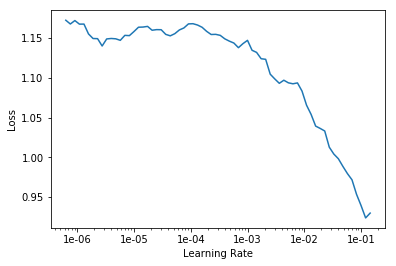

In [25]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [26]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.939216,1.013960,0.588235,00:19


In [27]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.784696,0.817733,0.705882,00:19


In [28]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.594593,0.604660,0.852941,00:26


In [29]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-2/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.453410,0.570546,0.823529,00:31
1,0.427740,0.535784,0.823529,00:29
2,0.430318,0.523609,0.823529,00:29
3,0.416011,0.516675,0.852941,00:29
4,0.409829,0.485860,0.852941,00:27
5,0.396947,0.487242,0.823529,00:28
6,0.389179,0.509034,0.823529,00:27
7,0.379638,0.505722,0.852941,00:28
8,0.369149,0.506481,0.823529,00:32
9,0.366159,0.510191,0.823529,00:28


In [40]:
learn.data.classes

['hold', 'lower', 'raise']

#### Predictions

In [31]:
#Chairman Powell August 23rd Speech
learn.predict('This years symposium topic is Challenges for Monetary Policy, and for the Federal Reserve those challenges flow from our mandate to foster maximum employment and price stability. From this perspective, our economy is now in a favorable place, and I will describe how we are working to sustain these conditions in the face of significant risks we have been monitoring. The current U.S. expansion has entered its 11th year and is now the longest on record.1 The unemployment rate has fallen steadily throughout the expansion and has been near half-century lows since early 2018. But that rate alone does not fully capture the benefits of this historically strong job market. Labor force participation by people in their prime working years has been rising. While unemployment for minorities generally remains higher than for the workforce as a whole, the rate for African Americans, at 6 percent, is the lowest since the government began tracking it in 1972. For the past few years, wages have been increasing the most for people at the lower end of the wage scale. People who live and work in low- and middle-income communities tell us that this job market is the best anyone can recall. We increasingly hear reports that employers are training workers who lack required skills, adapting jobs to the needs of employees with family responsibilities, and offering second chances to people who need one. Inflation has been surprisingly stable during the expansion: not falling much when the economy was weak and not rising much as the expansion gained strength. Inflation ran close to our symmetric 2 percent objective for most of last year but has been running somewhat below 2 percent this year. Thus, after a decade of progress toward maximum employment and price stability, the economy is close to both goals. Our challenge now is to do what monetary policy can do to sustain the expansion so that the benefits of the strong jobs market extend to more of those still left behind, and so that inflation is centered firmly around 2 percent. Today I will explore what history tells us about sustaining long, steady expansions. A good place to start is with the passage of the Employment Act of 1946, which stated that it is the continuing policy and responsibility of the Federal Government ... to promote maximum employment, production, and purchasing power.2 Some version of these goals has been in place ever since. I will divide the history since World War II into three eras organized around some well-known Greats. The first era comprises the postwar years through the Great Inflation. The second era brought the Great Moderation but ended in the Great Recession. The third era is still under way, and time will tell what Greats may emerge. Each era presents a key question for the Fed and for society more generally. The first era raises the question whether a central bank can resist the temptations that led to the Great Inflation. The second era raises the question whether long expansions supported by better monetary policy inevitably lead to destabilizing financial excesses like those seen in the Great Moderation. The third era confronts us with the question of how best to promote sustained prosperity in a world of slow global growth, low inflation, and low interest rates. Near the end of my remarks, I will discuss the current context, and the ways these questions are shaping policy. Era I, 1950–1982: Policy Breeds Macroeconomic Instability and the Great Inflation The late 1940s were a period of adjustment to a peacetime economy. As the 1940s turned to the 1950s, the state of knowledge about how best to promote macroeconomic stability was limited. The 1950s and early 1960s saw the economy oscillating sharply between recession and growth above 6 percent (figure 1, panel A). Three expansions and contractions came in quick succession. With the benefit of hindsight, the lack of stability is generally attributed to stop and go stabilization policy, as monetary and fiscal authorities grappled with how best to modulate the use of their blunt but powerful tools.3 Beginning in the mid-1960s, stop and go policy gave way to too much go and not enough stop—not enough, that is, to quell rising inflation pressures. Both inflation and inflation expectations ratcheted upward through four expansions until the Fed, under Chairman Paul Volcker, engineered a definitive stop in the early 1980s (figure 1, panel C). Each of the expansions in the Great Inflation period ended with monetary policy tightening in response to rising inflation. Policymakers came out of the Great Inflation era with a clear understanding that it was essential to anchor inflation expectations at some low level. But many believed that central bankers would find it difficult to ignore the temptation of short-term employment gains at the cost of higher inflation down the road.4 Era II, 1983 through 2009: the Great Moderation and Great Recession. As the second era began, inflation was falling, and it continued to fall for about a decade (figure 2, panel C). In 1993, core inflation, which omits the volatile food and energy components, first fell below 2.5 percent, and has since remained in the narrow range of 0.9 percent to 2.5 percent.5 Greater success on price stability came with greater success on employment. Expansions in this era were longer and more stable than before (figure 2, panel A). The era saw two of the three longest U.S. expansions up to that point in history.6 Anchored inflation expectations helped make this win-win outcome possible, by giving the Fed latitude to support employment when necessary without destabilizing inflation. The Fed was cutting, not raising, rates in the months prior to the end of the first two expansions in this era, and the ensuing recessions were mild by historical standards. And twice during the long expansion of the 1990s, the Federal Open Market Committee (FOMC) eased policy in response to threats to growth. In 1995, responding to evidence of slowing in the United States and abroad, the FOMC reduced the federal funds rate over a few months. In 1998, the Russian debt default and the related collapse of the hedge fund Long‑Term Capital Management rocked financial markets that were already fragile from the Asian financial crisis. Given the risks posed to the U.S. economy, the FOMC again lowered the federal funds rate over a period of months until events quieted. The 10-year expansion weathered both events with no discernible inflation cost.7 By the turn of the century, it was beginning to look like financial excesses and global events would pose the main threats to stability in this new era rather than overheating and rising inflation. The collapse of the tech stock bubble in 2000 and the September 11, 2001, terrorist attacks played key roles in precipitating a slowdown that turned into a recession.8 And the next expansion, as we are all painfully aware, ended with the collapse of a housing bubble and the Global Financial Crisis. Thus, this second era provided good reason for optimism about the Feds ability to deliver stable inflation, but also raised a question about whether long expansions inevitably lead to destabilizing financial excesses. Era III, 2010 and After: Monetary Policy and the Emerging New Normal. The third era began in 2010 as the recovery from the Great Recession was taking hold. My focus in discussing this era will be on a new normal that is becoming apparent in the wake of the crisis. I will fast-forward past the early years of the expansion and pick up the story in December 2015.9 The unemployment rate had fallen from a peak of 10 percent to 5 percent, roughly equal to the median FOMC participants estimate of the natural rate of unemployment at the time. At this point, the Committee decided that it was prudent to begin gradually raising the federal funds rate based on the closely monitored premise that the increasingly healthy economy called for more-normal interest rates. The premise was generally borne out: Growth from the end of 2015 to the end of 2018 averaged 2.5 percent, a bit above the 2.2 percent rate over the previous five years (figure 2, panel A). The unemployment rate fell below 4 percent, and inflation moved up and remained close to our 2 percent objective through much of 2018 (figure 2, panels B and C). That brings us to 2019. Before turning to issues occupying center stage at present, I want to address a long-running issue that I discussed here last year: tracking the stars that serve as guideposts for monetary policy.10 These include u*, the natural rate of unemployment, and r*, the neutral real rate of interest. Unlike celestial stars, these stars move unpredictably and cannot be directly observed. We must judge their locations as best we can based on incoming data and then add an element of risk management to be able to use them as guides. Since 2012, declining unemployment has had surprisingly little effect on inflation, prompting a steady decline in estimates of u* (figure 3).11 Standard estimates of r* have declined between 2 and 3 percentage points over the past two decades. Some argue that the effective decline is even larger.12 Incorporating a lower value of u* into policymaking does not require a significant change in our approach. The significant fall in r*, however, may demand more fundamental change. A lower r* combined with low inflation means that interest rates will run, on average, significantly closer to their effective lower bound. The key question raised by this era, then, is how we can best support maximum employment and price stability in a world with a low neutral interest rate. Current Policy and the Three Key Questions Let me turn now to the current implications for monetary policy of the questions raised by these three eras. The first era raised the question of whether the Fed can avoid excessive inflation. Inflation has averaged less than 2 percent over the past 25 years, and low inflation has been the main concern for the past decade. Low inflation seems to be the problem of this era, not high inflation. Nonetheless, in the unlikely event that signs of too-high inflation return, we have proven tools to address such a situation. The second eras question—whether long expansions inevitably breed financial excesses—is a challenging and timely one. Hyman Minsky long argued that, as an expansion continues and memories of the previous downturn fade, financial risk management deteriorates and risks are increasingly underappreciated.13 This observation has spurred much discussion. At the end of the day, we cannot prevent people from finding ways to take excessive financial risks. But we can work to make sure that they bear the costs of their decisions, and that the financial system as a whole continues to function effectively. Since the crisis, Congress, the Fed, and other regulatory authorities here and around the world have taken substantial steps to achieve these goals. Banks and other key institutions have significantly more capital and more stable funding than before the crisis. We comprehensively review financial stability every quarter and release our assessments twice a year to highlight areas of concern and allow oversight of our efforts. We have not seen unsustainable borrowing, financial booms, or other excesses of the sort that occurred at times during the Great Moderation, and I continue to judge overall financial stability risks to be moderate. But we remain vigilant. That leaves the third question of how, in this low r* world, the Fed can best support the economy. A low neutral interest rate presents both near-term and longer-term challenges. I will begin with the current context. Because todays setting is both challenging and unique in many ways, it may be useful to lay out some general principles for assessing and implementing appropriate policy and to describe how we have been applying those principles. Through the FOMCs setting of the federal funds rate target range and our communications about the likely path forward for policy and the economy, we seek to influence broader financial conditions to promote maximum employment and price stability. In forming judgments about the appropriate stance of policy, the Committee digests a broad range of data and other information to assess the current state of the economy, the most likely outlook for the future, and meaningful risks to that outlook. Because the most important effects of monetary policy are felt with uncertain lags of a year or more, the Committee must attempt to look through what may be passing developments and focus on things that seem likely to affect the outlook over time or that pose a material risk of doing so. Risk management enters our decisionmaking because of both the uncertainty about the effects of recent developments and the uncertainty we face regarding structural aspects of the economy, including the natural rate of unemployment and the neutral rate of interest. It will at times be appropriate for us to tilt policy one way or the other because of prominent risks. Finally, we have a responsibility to explain what we are doing and why we are doing it so the American people and their elected representatives in Congress can provide oversight and hold us accountable. We have much experience in addressing typical macroeconomic developments under this framework. But fitting trade policy uncertainty into this framework is a new challenge. Setting trade policy is the business of Congress and the Administration, not that of the Fed. Our assignment is to use monetary policy to foster our statutory goals. In principle, anything that affects the outlook for employment and inflation could also affect the appropriate stance of monetary policy, and that could include uncertainty about trade policy. There are, however, no recent precedents to guide any policy response to the current situation. Moreover, while monetary policy is a powerful tool that works to support consumer spending, business investment, and public confidence, it cannot provide a settled rulebook for international trade. We can, however, try to look through what may be passing events, focus on how trade developments are affecting the outlook, and adjust policy to promote our objectives. This approach is illustrated by the way incoming data have shaped the likely path of policy this year. The outlook for the U.S. economy since the start of the year has continued to be a favorable one. Business investment and manufacturing have weakened, but solid job growth and rising wages have been driving robust consumption and supporting moderate growth overall. As the year has progressed, we have been monitoring three factors that are weighing on this favorable outlook: slowing global growth, trade policy uncertainty, and muted inflation. The global growth outlook has been deteriorating since the middle of last year. Trade policy uncertainty seems to be playing a role in the global slowdown and in weak manufacturing and capital spending in the United States. Inflation fell below our objective at the start of the year. It appears to be moving back up closer to our symmetric 2 percent objective, but there are concerns about a more prolonged shortfall. Committee participants have generally reacted to these developments and the risks they pose by shifting down their projections of the appropriate federal funds rate path. Along with Julys rate cut, the shifts in the anticipated path of policy have eased financial conditions and help explain why the outlook for inflation and employment remains largely favorable. Turning to the current context, we are carefully watching developments as we assess their implications for the U.S. outlook and the path of monetary policy. The three weeks since our July FOMC meeting have been eventful, beginning with the announcement of new tariffs on imports from China. We have seen further evidence of a global slowdown, notably in Germany and China. Geopolitical events have been much in the news, including the growing possibility of a hard Brexit, rising tensions in Hong Kong, and the dissolution of the Italian government. Financial markets have reacted strongly to this complex, turbulent picture. Equity markets have been volatile. Long-term bond rates around the world have moved down sharply to near post-crisis lows. Meanwhile, the U.S. economy has continued to perform well overall, driven by consumer spending. Job creation has slowed from last years pace but is still above overall labor force growth. Inflation seems to be moving up closer to 2 percent. Based on our assessment of the implications of these developments, we will act as appropriate to sustain the expansion, with a strong labor market and inflation near its symmetric 2 percent objective. The Three Questions in the Longer Run Looking back over the three eras, monetary policy has evolved to address new challenges as they have arisen. The inflation targeting regime that emerged after the Great Inflation has led to vastly improved outcomes for employment and price stability around the world. One result has been much longer expansions, which often brought with them the buildup of financial risk. This new pattern has led us to understand that assuring financial stability over time requires much greater resilience in our financial system, particularly for our largest, most complex banks. As we look back over the decade since the end of the financial crisis, we can again see fundamental economic changes that call for a reassessment of our policy framework. The current era has been characterized by much lower neutral interest rates, disinflationary pressures, and slower growth. We face heightened risks of lengthy, difficult-to-escape periods in which our policy interest rate is pinned near zero. To address this new normal, we are conducting a public review of our monetary policy strategy, tools, and communications—the first of its kind for the Federal Reserve. We are evaluating the pros and cons of strategies that aim to reverse past misses of our inflation objective. We are examining the monetary policy tools we have used both in calm times and in crisis, and we are asking whether we should expand our toolkit. In addition, we are looking at how we might improve the communication of our policy framework. Public engagement, unprecedented in scope for the Fed, is at the heart of this effort. Through Fed Listens events live-streamed on the internet, we are hearing a diverse range of perspectives not only from academic experts, but also from representatives of consumer, labor, business, community, and other groups. We have begun a series of FOMC meetings at which we will discuss these questions. We will continue reporting on our discussions in the FOMC minutes and share our conclusions when we finish the review next year. I will conclude by saying that we are deeply committed to fulfilling our mandate in this challenging era, and I look forward to the valuable insights that will, I am confident, be shared at this symposium')

(Category hold, tensor(0), tensor([0.5953, 0.2221, 0.1826]))

In [41]:
#John Williams September 4 Speech
learn.predict("Thank you for the opportunity to speak this morning. In a speech Chair Powell gave last month, he said, “Low inflation seems to be the problem of this era, not high inflation.”1 Persistently low inflation is just one of the reasons the theme of this conference is very timely. Our Dual Mandate Goals And inflation is one of the topics I’m going to address today. The Fed has two goals set by Congress: maximum employment and price stability. These are also known as the dual mandate. When I talk about price stability, our objective is to keep the inflation rate near our symmetric 2 percent goal,2 so understanding inflation data and how it fits into the broader economic picture is critically important. This morning I’m going to set the scene for that broader economic picture and explain how changes in the landscape influenced the rate adjustment the Federal Open Market Committee (FOMC) made in July. I’ll then discuss the challenges on the horizon and how they feed into my thinking on monetary policy. This is as good a time as any to remind everyone that the views I express today are mine alone and do not necessarily reflect those of the Federal Open Market Committee or others in the Federal Reserve System.The Economic Outlook. If you do an online search about recent economic developments, the word “uncertainty” will come up a lot. And it’s true that uncertainty, both at home and abroad, is playing an important role in my thinking about the economic outlook and monetary policy, as I’ll discuss shortly. But when you take a step back and look at where things stand today relative to our goals, the economy is in a favorable place. The current expansion is the longest on record. The economy continues to grow at a moderate pace, as seen in the latest GDP numbers. And this growth has supported month after month of job gains and a pickup in wage growth in the past couple of years. Furthermore, the overall unemployment rate is near the lowest it has been in 50 years. And the benefits of the strong labor market have been broad across the population: Unemployment rates for African-Americans and Hispanics, while still higher than the overall rate, are near their all-time lows. These low rates aren’t just a fluke of how unemployment is measured in the official statistics—the broadest measure of underemployment, called U-6, is at its lowest level since 2000. These are all very positive signs when it comes to assessing our maximum employment goal. The economy is in a good place, but not without risk and uncertainty (there, I said it!). Persistently low inflation is a key area of my attention, with the core PCE inflation rate—which strips out volatile food and energy prices—running at 1.6 percent, nearly half a percentage point below our 2 percent longer-run target. On its own, inflation somewhat below our longer-run goal would not be such a big deal, especially with our economy strong. But the broader context is important. Ongoing disinflationary pressures from abroad, and the risk that inflation expectations in the U.S. may have drifted down after many years of inflation running below 2 percent, form an important part of this picture. If we look beyond the headline GDP figure, which remains good, there are more mixed signals coming from different sectors. Robust consumer spending is balanced by signs of slowing business investment. We’ve also seen a decline in exports and weakening manufacturing data, reflecting slowing global growth and uncertainty related to trade and geopolitical risks. I am carefully monitoring this nuanced picture and remain vigilant to act as appropriate to support continuing growth, a strong labor market, and a sustained return to 2 percent inflation. Monetary Policy Adjustments. This brings me to our decision to lower the federal funds rate in July and how that fits into recent history. Cast your minds back to a year ago, when the Fed was continuing along the path of normalizing monetary policy. This context provides useful information for how and why our stance has evolved over time. During the summer of 2018, the economy was growing above trend as businesses rode the wave of fiscal stimulus. The unemployment rate had fallen below 4 percent, a figure not seen since the peak of the tech boom in 2000. The global outlook was still quite positive, and inflation was close to our 2 percent goal. Against that backdrop, very gradually bringing interest rates back to more normal levels was appropriate in order to keep the economy on a sustainable path of growth. But the economic outlook and the uncertainty around that outlook have evolved considerably since then. While there’s not been a dramatic change seen in the overall numbers yet, the more detailed picture that emerged by summer of this year pointed to an outlook of slowing growth and inflation falling short of our goal. This in turn argued for a somewhat more accommodative monetary policy stance. The combination of muted inflation, slowing global growth, and uncertainties related to trade and other global developments led the FOMC to adjust the federal funds rate down by a quarter of a percentage point and conclude the run-off of the Fed’s balance sheet two months earlier than previously indicated. Our policy actions and communications have contributed to an easing of financial conditions that should help sustain the expansion and get us closer to our dual mandate goals. Challenges on the Horizon. When I think about the road ahead, my number one goal is to keep the expansion on track. This is how we will keep unemployment low and bring inflation back to 2 percent. I will be watching closely at how both domestic and broader, global developments unfold.At present, slowing global growth and geopolitical uncertainty pose particular challenges. In its latest World Economic Outlook report, the International Monetary Fund downgraded its projection for global growth and highlighted downside risks. Slower global growth reduces demand for our exports and puts a dampener on both U.S. inflation and growth prospects. And these aren’t just projections for the future—we’re seeing manifestations of slowing growth around the world now. Germany, the UK, and China are all experiencing slowdowns, and the euro area is of particular concern. In response, the European Central Bank and several other central banks have either adjusted, or indicated they will adjust their monetary policy stance to support their economies. These concerns about global growth are compounded by broader geopolitical uncertainty. The risk of a no-deal Brexit for the UK is looming large, the political situation in Italy remains fraught, political tensions continue in Hong Kong, and Argentina’s economy is coping with a debt crisis. On our own shores, concerns around trade policy with China are adding to an uncertain picture. My contacts in the business community have said this is making them more cautious about investment. The effects of this angst are already showing up in the investment numbers. An additional fly in the ointment, if you will, is the recently released downward revision for GDP growth covering last year and an announced estimate of a sizable downward revision to payroll employment. One implication of these revisions is that the economy’s underlying momentum was already somewhat less robust than previously thought, even before recent developments pointed to a less rosy outlook. The Path Forward. So what will the response from the Fed be to all of these developments? Our role is to navigate a complex and at times ambiguous outlook to keep the economy growing and strong. As events unfold and conditions evolve, it’s critical we understand which developments are mere bumps in the road and those that will affect the outlook in a material way over the longer term. That means maintaining a data-dependent approach that takes into account the risks and uncertainty that are weighing on the economy. I will continue to consult everything from very granular data about individuals’ experiences of employment conditions, through to the macro projections for global growth. We need to consider all of the information available and be flexible in our response. Conclusion. Low inflation is indeed the problem of this era. The current outlook of moderate growth, low unemployment, but stubbornly low inflation is a reflection of the broader economic picture—the July rate adjustment an appropriate response to ease financial conditions and support the economy. How the U.S. outlook evolves in the future is fundamentally tied to the fortunes of the economies around the world. As I look ahead, I’m keeping a keen eye on all the data, both domestic and global, and the implications for our economy. With an uncertain outlook, vigilance and flexibility are essential for achieving our dual mandate goals of maximum employment and price stability. Persistently low inflation, heightened uncertainty, and global cross-currents make this a particularly challenging time for monetary policy, and my laser focus is on doing the best we can to support a strong economy and achieve our 2 percent inflation goal. Thank you.")

(Category hold, tensor(0), tensor([0.5717, 0.3063, 0.1220]))

In [43]:
#James Bullard August 23 Speech
learn.predict("What the market thinks inflation is going to be over the next five years, let’s say. And you adjust it, because it’s CPI, you adjust it to PCE. Market’s only expecting about 1% or 1.1% inflation. So, we’re supposed to hit our inflation target. That’s one reason why I’ve argued that, you know, we should get lower here. Well, you know. Yield curve’s inverted here. We have one of the higher rates on the whole yield curve. That’s not a good place to be, I think. Yes. Well, I see the curve’s trading up a little today. But yeah, basically. Yeah. So, I mean, obviously, a down draft in global yields and we’re going to talk about that and trade war, all that. I think the Fed needs to stay consistent with where yields are trading. I think consumption looks pretty good. Obviously labor markets continue to do well in the U.S. and we’ll keep an eye on that. Some of the retail sales that came out, last week, very good. I guess some this week, too. So, you know, all of that looks good. I think the question is, looking forward, you know, how much risk are we facing from the fact that you’ve got a global manufacturing contraction going on? And possibly more to come. So, there’s down side risk and I think you’d like to take out insurance against that downside risk. And I’d like to take out more insurance against a down side risk. But the good side is, okay, nothing happens, the U.S. economy continues to grow, we can take the insurance back next year if it turns out that this is all going to blow over. Yeah, the agri-business sector has not been good for the last couple of years. This year you had a combination of very wet weather all across our district -- really delayed planting and made people change plans, even not plan at all. And then in addition, you’ve got the trade war going on, which is very much hitting the AG sector very directly. Okay. Now let’s take a step back. The President argues, among other things, that our rates are high relative to Germany and other countries around the world. And he also further argues they’re keeping rates low in order to keep their currency low and gain advantage on exports. How do you respond? Is that an argument you agree with? You know, I’d like to see how the, that market would react to what we’re doing. But it doesn’t give me a lot of confidence. We’ve missed our inflation target to the low side since 2012 basically -- Yeah. Continuously. And now you’re looking out five years and you’re telling me again, you know -- Yeah. So, I -- you’d like inflation, the U.S. economy a surprise to the upside the last 2.5 years. And you would expect inflation to be probably above target in this environment. And that’s not the situation we’re in. So, I’d like to focus on that and get that to happen. You know, I think the trade war has a lot more impact outside the U.S. than it does inside the U.S. So, we’re all stressing about it here, but if you’re a small country outside the U.S., you’re very concerned about what the future holds. So, they’re not going to make the billion-dollar investment. They’re not going to build the new factory while all of this uncertainty is in the air. So, you see the global economy somewhat slower than it was, and possibly getting slower still. That’s feeding back to U.S. equities and to U.S. bond markets. Well, I don’t think that we have a financial bubble on the order of magnitude of the internet bubble or the housing bubble. But I am sympathetic to the idea that we could face problems going forward. I’m not sure interest rate policy is necessarily the way to handle that. I think you’d like to handle that sort of thing through other channels. Yeah, I mean, we’re always operating on the margin. And so, yeah, sure, there are marginal effects and it would stimulate interest sensitive sectors. And I think that’s as powerful as ever. And so that you would have some effect from that. Is it going to solve every problem in the economy? Absolutely not. There are many other things and other types of policies that have to be used to address other issues. It does seem like the deficit hawks have -- are on vacation in Washington. So, I don’t know. I would say this: I do think it’s time to re-evaluate our models of government debt and what we think is too much government debt. We’ve the Maastricht treaty – it has been around for 20 years, it enshrined the idea of 60% debt to GDP ratio was a reasonable number -- pretty much every country is over that and has, many of them have not experienced dire consequences from that. So, I think we need to think more carefully about the – Yeah. Well, I wish I knew. But I’m saying that it’s time to have this discussion in the macro community. I don’t think you can just harken back to the Maastricht treaty and say that’s the number we’ve got to hit every day. Yeah, I’ve long argued we’re in this low interest rate regime and we just have to respect that. And that sort of talk has come out in other ways in the monetary policy debate. But, you know, it’s just not your grandfather’s economy and you can’t be thinking about the policy rate at 5% as being sort of the normal rate, the way it was in the 1990s. We’re operating at a lower level. But nevertheless, at that lower level, we might take out insurance in some circumstances. We might take it back in other circumstances. I don’t know if you remember this ’98 example. 1998, you had the Asian Currency Crisis going on. A very similar situation. A lot of uncertainty abroad. We were worried about that coming back to the U.S. We lowered the rate, I think, a total 75 basis points. And then, not too much really happened partly because we got the benefit of lower interest rates in the U.S. -- so not very much happened in the U.S. then the Fed took those back gradually over the subsequent period. So, I think that that’s a good model or a good baseline case for what could go on here. You take out the insurance. If you -- if nothing happens, you take it back. I don’t want to -- I’m not speaking for Jay. I’m speaking for me. Yeah. But I do like those examples. And I think those were cases where things were played very, very well. And it’s always the case with insurance, where you can say, well, you know, you made these cuts and it turned out the economy continued to grow. But that’s okay. Then you can just come back and take the cuts back. So many things affect the dollar, including the quality of the foreign economies and the foreign policymakers and what they’re doing. If you look at the trade weighted dollar over the last two and a half years, yeah, it fluctuates but it’s not that different than it was two and a half years ago. So, I mean, as a macro guy, I kind of say, ‘Well, it looks kind of the same.’ If you’re in the market every day and you’re trying to make your quarterly earnings, you’re going to be pretty concerned about it. But I don’t feel like we’ve gone overboard on the dollar here.")

(Category hold, tensor(0), tensor([0.7522, 0.0887, 0.1592]))

In [44]:
#Esther George Aug 22nd Interview on CNBC
learn.predict("My sense was we’ve added accommodation and it wasn’t required in my view. So, i’m observing the downside risk. And right now, I’m really focused on what the federal reserve has to do to achieve its mandates. And in my view with this very low unemployment rate, with wages rising, with the inflation rate staying close to the Fed’s target, I think we’re in a good place relative to the mandates that we are asked to achieve. Last year was a stronger performance. And I thought 2019 would not be as strong. But still coming in around 2%. So, for my outlook, I think 2% growth still looks possible for the U.S.I think they are tilted to the downside. And I thought that for some time as you look at global growth weakening. And as you look at the amount of uncertainty associated with some of these trade issues. I think both of those are weighing on the outlook. Whether they begin to spill over in a way that we see the effects on the real economy is what I’m watching for. It does seem persistent at this stage. and it’s hard to see how it will be resolved. So, you have to take that as it comes in terms of watching for data, it signals it’s having an effect on the economy. I think you probably see it in business investment. We hear that from our own business contacts, which are trying to think about what the implications are for their particular business. It may cause them to pull back on some of their investments. So, I think we are beginning to see some of those effects there. So, the AG community in my region has experienced low farm incomes for a number of years now, going on five years now, well ahead of these trade issues. Having markets disrupted, particularly for example in the soy bean production area has been another leg down for the AG sector. And so, this puts pressure on an already difficult situation. It’s incredible, I think. It is part of, I think, an experiment that we’re watching to see whether negative interest rates will have the stimulative effect that Central Banks are looking for. I would never say never. I don’t see it for the U.S. right now. Remember, we already have real interest rates at 0 right now. If you think about where inflation is and where the current Federal funds rate is. So, policy is not tight in my view in the United States. And I think as the economy grows, I don’t see a scenario for that right now. So, we all know what the history is of inverted yield curves and the concern that they portend a recession coming. I think, I look at that very carefully to try to understand why are we seeing that? But in the context of a global economy that is weakening, I think that could be explaining a part of it. I think the Fed still has a large balance sheet and that could be putting some downward pressure on the lower term rates. So, I’ll keep watching that carefully for sure. But, I don’t yet see the signal that suggests it’s time to get worried about a downturn. I think if you look at the underlying performance of those other economies, you will see the U.S. Is performing better than, for example, Europe and other parts of the world. And that accounts for why we have higher interest rates. I don’t tend to think of it this way. I tend to think that those rates in the U.S. are reflecting the underlying economy here, the interest rates in other countries likewise are reflecting that. And to address that issue really requires other policies in those countries, whether it’s fiscal or monetary, to really affect that growth.")

(Category hold, tensor(0), tensor([0.7073, 0.1039, 0.1888]))

In [45]:
#Eric Rosengren Speech at Stonehill College
learn.predict("Good afternoon. Let me begin by thanking Stonehill College for inviting me to speak. And let me also congratulate the College on the opening of the new Meehan School of Business. Summer is usually regarded as a time to be more relaxed, take some vacation time, and put your worries aside. In summertime, Gershwin suggested, the livin’ is easy. Unfortunately, this year, the financial markets didn’t get the memo. August saw a series of announcements regarding possible additional tariffs; discussions about possible future tax cuts; a significant fall in the 10-year Treasury rate, which now stands at 1.5 percent; and a one-day decline in the Dow Jones Industrial Average of over 800 points, followed by elevated volatility in the Dow over subsequent days. Indeed, it has not exactly been a low-key, calm summer in the markets. Which begs the question – what are these financial market gyrations telling us about the economic outlook? Let me point out that despite these headline-grabbing swings in financial conditions, domestic economic conditions have remained relatively benign: The economy grew by 2 percent in the second quarter, and forecasters are expecting growth in the next two quarters to be similar. The unemployment rate reached a nearly 50-year low of 3.6 percent in April, and currently stands at 3.7 percent. Forecasters are expecting these near-record lows to continue for at least the next two quarters. Inflation, as measured by the PCE price index, is running below the Federal Reserve’s 2 percent target, but an alternate measure that removes outsized moves that are likely to represent one-off changes – known as the Dallas trimmed mean PCE – shows inflation running at 2 percent. So, with economic conditions relatively strong, why has financial market volatility picked up so markedly this summer? Financial market participants are certainly concerned that risks related to international trade and geopolitics have intensified. Tariffs are a tax on imported goods and, along with the impact of retaliatory tariffs, they increase the risk that the earnings of firms reliant on foreign trade will be hurt. The reduction in earnings for these firms could affect asset valuations. In addition, and perhaps more importantly, potential trade disruptions are emerging at a time when many U.S. trading partners are facing mounting economic challenges. For example, China, the world’s second-largest economy, faces a number of concerns about the future robustness of its economy. China is heavily reliant on trade, so trade restrictions will take a bite out of the country’s economic activity. Moreover, the situation in Hong Kong is raising concerns on many levels, including from an economic standpoint. Other countries are vulnerable to possible U.S. tariffs as well. Japan, South Korea, and many European economies are even more dependent on trade than the United States and face a number of unusual challenges of their own. Exploring the Yield Curve: In addition to these important global headwinds, we see that yields on the 10-year U.S. Treasury bond have fallen below many short-term yields, resulting in an inverted yield curve. In the past, yield curve inversions have often preceded economic downturns. However, the current situation is somewhat different, in my assessment. Previously, most of the yield curve inversions were driven by the Federal Reserve raising short-term rates well above the level expected to prevail in the long run, in order to slow the economy down and prevent inflation from accelerating. Today, the short-term interest rate that the Federal Reserve targets, the federal funds rate, is at a level roughly equal to our 2 percent inflation target and still below its expected level in the long run. Rather than policy actions by the Fed that raise the short-term rate, what is currently driving the yield curve inversion is the decline in the longer-term rate. The depressed long-term yield, in part, reflects the challenging economic conditions in much of the rest of the world. Currently, U.S. government bond yields (determined, of course, in the marketplace, not set by policymakers) are higher than those in most other developed countries. This provides an incentive for foreign investors to buy U.S government securities, especially if the risk of a dollar depreciation is perceived as low. But such an increase in demand pushes the prices of U.S. government securities up, and yields down. Weighing the Risks, and Considering Policy. The core question of my remarks today, then, is this: As we all look ahead and evaluate the economy’s prospects, how should the relatively good domestic economy and forecasts for the second half of this year be seen against significant risks from trade, a slowdown in some of our trading partners, and the low long-term rates creating an inverted yield curve? At times like this, it is important to carefully study incoming economic data. If the risks become pronounced and threaten the U.S. outlook, then further monetary easing may be appropriate. However, if the data continue to indicate a U.S. economy growing slightly above the level considered to be the economy’s potential growth rate (an estimate of the economy’s maximum sustainable output over the long term4), with continued gradual increases in wages and prices, then in my view, no immediate policy action would be required. In fact, the gradual slowing of GDP growth that we are seeing is really not surprising – and is not necessarily a signal of a weakening economy headed for a recession, but instead a natural pattern. As resource constraints (like the availability of workers) become more binding and the effects of the fiscal stimulus wane, and with monetary policy only marginally accommodative, economists would expect actual economic growth to settle in the vicinity of the growth rate associated with the economy’s potential. Economic Forecasts and Indicators: In the spirit of the data dependence, let’s now turn to the numbers. Figure 1 shows the growth in real GDP for the first two quarters of 2019 and the Blue Chip consensus forecast through a year from now. The Blue Chip panel comprises roughly 50 professional forecasters who provide their estimates of the future state of a variety of economic variables. Actual second quarter growth in real GDP was 2 percent. The Blue Chip forecasters expect real GDP to grow at a 2 percent annualized rate for each of the next two quarters. My own forecast is quite similar, anticipating growth in the second half of this year of 2 percent – which is somewhat above my estimate of the potential growth rate in the economy. Growth above that potential rate is what drives unemployment lower, which may further boost wage and price inflation. Figure 2 illustrates some of the drivers of second quarter growth. Real GDP growth was 2 percent, despite weakness in business fixed investment, residential investment, and exports, as very strong growth in consumer spending offset the weakness in these other components of real GDP. If the consumer continues to spend, and global conditions do not deteriorate further, the economy is likely to continue to grow around 2 percent, in part because the underpinnings of consumption growth — household income growth and household wealth — remain strong, and consumption accounts for about 70 percent of GDP in the U.S. To that end, Figure 3 shows that data we have to date on retail sales are consistent with continued relatively strong consumption. In fact, retail sales growth for July was stronger than the growth in any of the previous three months. However, Figure 4 shows that the University of Michigan consumer sentiment survey did decline in August, suggesting consumers may have focused their attention on gyrations in the stock market and the possibility of another round of tariffs, although the measure has not yet deviated meaningfully from its range since the beginning of 2017. By contrast, the Conference Board Consumer Confidence index was little changed in August relative to July. But in sum, as long as employment continues to expand as it has – even recently – the consumer should remain a source of strength for the economy. However, tariff-related trade disruption and weakness in the global economy remain key risks for the U.S. economy. That said, Figure 5 shows exports as a percent of GDP for a number of nations. Countries with a large export share of GDP will be highly sensitive to slowing global market conditions and the imposition of tariffs. Among the countries shown, the United States stands out as having a relatively small export share of GDP, at just 12 percent. In contrast, Germany, South Korea, and Italy are much more highly exposed to global trade.5 To date, economic forecasts and the underlying data are consistent with a U.S. economy growing slightly above its potential rate. However, the forecasts and recent data highlight that continued strong consumption is key to that outlook. Because of tariffs and slowing global growth, both business fixed investment and exports have been weak. Clearly, there is a downside risk that trade or geopolitical problems could escalate, resulting in a much weaker situation than is currently anticipated in economic forecasts. Financial Market Indicators: As I mentioned earlier, one source of concern with the economic outlook involves recent movements in financial markets. Figure 6 shows the 3-month and 10-year Treasury yields, with recession shading. The 10-year Treasury yield rose to 3.24 early last November and is currently about 1.5 percent. This is obviously a very sizable decline, and much more substantial than the decline in short-term rates. The current rate configuration in the United States, with the yield curve inversion, should be placed in the context of the interest rates prevailing in other developed economies. Figure 7 shows the monetary authority’s policy rate in Europe, Japan, and the United States. While the U.S. central bank has raised the policy rate over the past several years, in Japan and the Euro area the policy rate has not been raised, reflecting the weakness of these economies relative to the United States. Because the policy rate remains near the effective lower bound in Europe and Japan, the central banks there have been providing monetary stimulus by purchasing long-term securities. Figure 8 shows rates on 10-year government bonds in the U.S., Germany, and Japan. Particularly striking is the 10-year German rate, which is now more than 200 basis points lower than the comparable U.S. rate, and is more negative than the European central bank’s short-term policy rate. The weakness in Japan and Europe, and the associated easing across the yield curve, causes foreign investors to search for higher yields in the United States. This has encouraged foreign investors to buy 10-year U.S. Treasuries.6 In addition to the higher yield, U.S. Treasuries provide a “recession hedge” — in an economic downturn here or abroad, the safety and relatively high yields of long-term U.S. government bonds would likely become even more attractive to investors, so their prices would rise and yields decline further. Holding long bonds today thus offers the prospect of capital gains during a downturn, which would partly insulate investors against the losses on other assets in their portfolios that would likely arise in such circumstances. These alternative explanations for what makes U.S. Treasuries attractive today are challenging to disentangle, making the decline in long-term U.S. Treasury rates somewhat open to interpretation. To the extent that the decline reflects weakness in foreign economies with limited policy space, that foreign weakness is likely already incorporated into economic forecasts. If instead the rate is falling due to perceptions that an economic downturn here is becoming more likely, then one would have to say that the view from bond markets diverges from that of most economic forecasters and constitutes a downside risk to the forecasts. But the financial markets are sending mixed signals about economic risks. If one thought that the economy was going into an economic downturn, one would expect such concerns to be reflected in equity prices, as corporate earnings tend to decline significantly in a recession. Figure 9 shows the S&P 500 and Dow Jones averages. While both indices are down a little more than 3 percent from their July highs, overall stock prices remain robust. Recession concerns do not seem to be reflected in the current pricing of stocks. Another market indicator that can reflect recession concerns is the spread between yields on BAA-rated corporate bonds (bonds with the lowest of the “investment grade” ratings) and 10-year Treasury yields, as shown in Figure 10. This spread, which would grow if perceived risks about private sector investments were heightened, is not unusually elevated, as we would expect if bond investors were concerned about a near-term recession. In sum, one widespread interpretation of the inversion in the Treasury yield curve is that it portends a likely economic downturn in the United States. I would say, however, that such a view does not seem to be strongly echoed in equity markets, bond spreads, or economic forecasts. A plausible alternative explanation would be weakness among U.S. trading partners has depressed long rates in their countries, which has, in turn, depressed long-term Treasury rates in the United States by shifting demand to long-term Treasuries, inverting the yield curve. We are wise not to place too much confidence in either interpretation, but instead watch closely for signs of risks materializing in the economic data. Inflation Considerations. Another potential concern is that inflation has remained consistently below the 2 percent goal that the Fed has announced and intends to deliver. Figure 11 shows core PCE inflation and the Dallas trimmed mean PCE. Both measures try to remove “noise” from the measured inflation rate. The Dallas trimmed mean, as previously stated, removes any unusual outliers in the inflation series and is currently at 2 percent. Core PCE, which removes the often-volatile food and energy prices, is at 1.6 percent. During previous periods when the series have diverged, core PCE has tended to move toward the Dallas trimmed mean. This would be consistent with a situation where the recent low readings in core PCE reflect transitory changes in prices (other than food and energy) that are removed by the Dallas trimmed mean measure. Figure 12 shows that wages and salaries, using either average hourly earnings or the Employment Cost Index, have been slowly increasing. As wages rise, unless productivity rises as well to offset the increase in production costs, firms will need to decide whether to reduce margins or raise prices. The gradual increase in wages and salaries is consistent with a tight labor market. With the unemployment rate at 3.7 percent, this tightness in labor markets should also gradually cause inflation to return to the Federal Reserve’s 2 percent target.Concluding Observations Concerns over tariffs and geopolitical uncertainties have increased discussion around a possible economic downturn. It is clearly reasonable to make the assessment that risks are elevated. Should those risks become a reality, the appropriate monetary policy would be to ease aggressively. However, to date, these elevated risks have not become reality, at least for the U.S. economy. Economic forecasts – and, as I’ve demonstrated, many financial market indicators – remain benign, consistent with a forecast of growth slightly above potential. In my view, one should not be overconfident that the economy will be just fine or that an economic downturn is inevitable. As a result, this is a particularly good time to carefully watch incoming data – to determine whether any additional policy adjustments are necessary to achieve the Fed’s Congressionally mandated goals of maximum employment and stable prices. Returning to where I started my remarks, I’ll just say that is how I plan to spend the last few days of summer, and beyond.")

(Category hold, tensor(0), tensor([0.5543, 0.1858, 0.2599]))

In [47]:
#July FOMC Minutes
learn.predict("Review of Monetary Policy Strategy, Tools, and Communication Practices. Committee participants began their discussions related to the ongoing review of the Federal Reserves monetary policy strategy, tools, and communication practices. Staff briefings provided a retrospective on the Federal Reserves monetary policy actions since the financial crisis, together with background and analysis regarding some key issues. In its policy response during the recession and the subsequent economic recovery, the Committee lowered the federal funds rate to its effective lower bound (ELB) and provided additional monetary policy accommodation through both forward guidance about the expected path of the policy rate and balance sheet policy. These actions eased financial conditions and provided substantial support to economic activity; they therefore figured importantly in helping promote the recovery in the labor market and in preventing inflation from falling substantially below the Committees objective. The presentation noted, however, that over the past several years, inflation had tended to run modestly below the Committees longer-run goal of 2 percent, while some indicators of longer-run inflation expectations currently stood at low levels. The staff also provided results from model simulations that illustrated possible challenges to the achievement of the Committees dual-mandate goals over the medium term. These challenges included the proximity of the policy rate to the ELB, imprecise knowledge about the neutral value of the policy rate and the longer-run normal level of the unemployment rate, the diminished response of inflation to resource utilization, and uncertainty about the relationship between inflation expectations and inflation outcomes. In their discussion, participants welcomed the review of the monetary policy framework. They noted that the inclusion of feedback from the public as part of the review, via the Fed Listens events, had improved the transparency of the review process, enhanced the Federal Reserves public accountability, and provided insights into the positive implications of strong labor markets and high rates of employment for various communities. Furthermore, participants agreed that the review was timely and warranted, in light of the use over the past decade of new policy tools and the emergence of changes in the structure and operation of the U.S. economy. These changes included the long period during which the federal funds rate was at the ELB, the probable recurrence of ELB episodes if the neutral level of the policy rate remains at historically low levels, and the challenges that policymakers face in influencing inflation and inflation expectations when the response of inflation to resource utilization has diminished. Participants generally agreed that the Committees consideration of possible modifications to its policy strategy, tools, and communication practices would take some time and that the process would be careful, deliberate, and patient. With regard to the current monetary policy framework, participants agreed that this framework had served the Committee and the U.S. economy well over the past decade. They judged that forward guidance and balance sheet actions had provided policy accommodation during the ELB period and had supported economic activity and a return to strong labor market conditions while also bringing inflation closer to the Committees longer-run goal of 2 percent than would otherwise have been the case. In addition, participants noted that the Committees balanced approach to promoting its dual mandate of maximum employment and price stability had facilitated Committee policy actions aimed at supporting the labor market and economic activity even during times when the provision of accommodation was potentially associated with the risk of inflation running persistently above 2 percent. Participants further observed that such inflation risks—along with several of the other perceived risks of providing substantial accommodation through nontraditional policy tools, including possible adverse implications for financial stability—had not been realized. In particular, a number of participants commented that, as many of the potential costs of the Committees asset purchases had failed to materialize, the Federal Reserve might have been able to make use of balance sheet tools even more aggressively over the past decade in providing appropriate levels of accommodation. However, several participants remarked that considerable uncertainties remained about the costs and efficacy of asset purchases, and a couple of participants suggested that, taking account of the uncertainties and the perceived constraints facing policymakers in the years following the recession, the Committees decisions on the amount of policy accommodation to provide through asset purchases had been appropriate. In their discussion of policy tools, participants noted that the experience acquired by the Committee with the use of forward guidance and asset purchases has led to an improved understanding of how these tools operate; as a result, the Committee could proceed more confidently and preemptively in using these tools in the future if economic circumstances warranted. Participants discussed the extent to which forward guidance and balance sheet actions could substitute for reductions in the policy rate when the policy rate is constrained by the ELB. Overall, participants judged that the Federal Reserves ability to provide monetary policy accommodation at the ELB through the use of forward guidance and balance sheet tools, while helpful in mitigating the effects of the constraint on monetary policy arising from the lower bound, did not eliminate the risk of protracted periods in which the ELB hinders the conduct of policy. If policymakers are not able to provide sufficient accommodation at the ELB through the use of forward guidance or balance sheet actions, the constraints posed by the ELB could be an impediment to the attainment of the Federal Reserves dual-mandate objectives over time and put at risk the anchoring of inflation expectations at the Committees longer-run inflation objective. Participants looked forward to a detailed discussion over coming meetings of alternative strategies for monetary policy. Some participants offered remarks on general features of some of the monetary policy strategies that they would be discussing and on the relationship between those strategies and the current framework. A few of the options mentioned were makeup strategies, in which the realization of inflation below the 2 percent objective would give rise to policy actions designed to deliver inflation above the objective for a time. In principle, such makeup strategies could be designed to promote a 2 percent inflation rate, on average, over some period. In such circumstances, market expectations that the central bank would seek to make up inflation shortfalls following periods during which the ELB was binding could help ease overall financial conditions and thus help support economic activity during ELB episodes. However, many participants noted that the benefits of makeup strategies in supporting economic activity and stabilizing inflation depended heavily on the private sectors understanding of those strategies and confidence that future policymakers would take actions consistent with those strategies. A few participants suggested that an alternative means of delivering average inflation equal to the Committees longer-run objective might involve aiming for inflation somewhat in excess of 2 percent when the policy rate was away from the ELB, recognizing that inflation would tend to move lower when the policy rate was constrained by the ELB. Another possibility might be for the Committee to express the inflation goal as a range centered on 2 percent and aim to achieve inflation outcomes in the upper end of the range in periods when resource utilization was high. A couple of participants noted that an adoption of a target range would be consistent with the practice of some other central banks. A few other participants suggested that the adoption of a range could convey a message that small deviations of inflation from 2 percent were unlikely to give rise to sizable policy responses. A couple of participants expressed concern that if policymakers regularly failed to respond appropriately to persistent, relatively small shortfalls of inflation below the 2 percent longer-run objective, inflation expectations and average observed inflation could drift below that objective. Participants also discussed the Committees Statement on Longer-Run Goals and Monetary Policy Strategy. Participants noted that this statement had been helpful in articulating and clarifying the Federal Reserves approach to monetary policy. The Committee first released this document in January 2012 and had renewed it, with a few modifications, every year since then. On the basis of the monetary policy and economic experience of the past decade, participants cited a number of topics that they would likely discuss in detail in their deliberations during the review and that might motivate possible modifications to the statement. These topics included the conduct of monetary policy in the presence of the ELB constraint, the role of inflation expectations in monetary policy, the best means of conveying the Committees balanced approach to monetary policy and the symmetry of its inflation goal, the relationship between the Committees strategy and its decisions about the settings of its policy tools, the implications of the low value of the neutral policy rate and of uncertainty about the values of the neutral policy rate and the longer-run normal rate of unemployment, the potential benefits and costs of unemployment running below its longer-run normal rate in conditions of muted inflation pressures, and the time frame over which policymakers aimed to achieve their dual-mandate goals. A couple of participants emphasized the availability to policymakers of other communication tools through which the Committee could elaborate on its policy strategy and the challenges that monetary policy faced in the current environment, while also indicating that the Committee retains flexibility and optionality to achieve its objectives. Participants highlighted the importance of the Summary of Economic Projections (SEP) in conveying participants modal outlooks, with several participants suggesting that modifications to the SEPs format might enhance policy communications. Participants also commented on the importance of considering the connections between monetary policy and financial stability. Participants expected that, at upcoming meetings, they would continue their deliberations on the review of the Federal Reserves monetary policy strategy, tools, and communication practices. These additional discussions would consider various topics, such as alternative policy strategies, options for enhanced use of existing monetary policy tools, possible additions to the policy toolkit, potential changes to communication practices, the relationship between monetary policy and financial stability, and the distributional effects of monetary policy. Developments in Financial Markets and Open Market Operations. The manager pro tem discussed developments in financial markets over the intermeeting period. Regarding market participants views about the July FOMC meeting, nearly all respondents from the July Open Market Desk surveys of dealers and market participants expected a 25 basis point cut in the target range for the federal funds rate, a substantial shift from the June surveys when a significant majority had a modal forecast for no change. Survey responses also suggested that expectations had coalesced around a modal forecast for a total of two 25 basis point cuts in the target range in 2019 and no change thereafter through year-end 2021. Regarding balance sheet policy, survey respondents that expected a rate cut at this meeting were almost evenly split on whether the Committee would also choose to end balance runoff immediately after the meeting or to maintain the existing plan to halt runoff at the end of September. Market participants generally judged that a two-month change in the timing of the end of the balance sheet runoff would have only a small effect on the path of the balance sheet and thus very little, if any, economic effect. Expectations for near-term domestic policy easing had occurred against the backdrop of a global shift toward more accommodative monetary policy. Several central banks had eased policy over the past month and a number of others shifted to an easing bias. Market participants were particularly attentive to a statement after the European Central Banks Governing Council meeting that was perceived as affirming expectations for further easing and additional asset purchases. These changes to the policy outlook in the United States and across a number of countries appeared to play an important role in supporting financial conditions and offsetting some of the drag on growth from trade tensions and other risks. Somewhat reduced concern among market participants about important risks to the global outlook also appeared to support risk asset prices. Following the G-20 (Group of Twenty) meeting in late June, fewer Desk contacts and respondents to the Desk surveys expected a significant escalation of U.S.-China trade tensions. In addition, investor sentiment was bolstered by news that the Administration and Congress had reached a budget and debt ceiling agreement that, if passed, would remove another source of risk later this year. That said, contacts recognized that some potentially sizeable downside risks remained. Many survey respondents still viewed U.S.-China trade risks as skewed to the downside, and many Desk contacts judged that the risks of a no-deal Brexit had increased. The manager pro tem next discussed developments in money markets and open market operations. The spreads of the effective federal funds rate (EFFR) and the median Eurodollar rate relative to the interest on excess reserves (IOER) rate had increased some and become more variable over recent months, with a notable pickup in daily changes in these spreads since late March. Moreover, the range of rates in unsecured markets each day had widened. Market participants pointed to pressures in repurchase agreement (repo) markets as one factor contributing to the uptick in volatility in unsecured rates. These pressures, in turn, seemed to stem partly from elevated dealer inventories of Treasury securities and dealers associated financing needs. Market participants also pointed to lower reserve balances as a factor affecting rates in unsecured money market rates. Over the intermeeting period, the level of reserves was little changed on net; however, some market participants noted the association between the gradual increase in unsecured rates relative to the IOER rate over recent months and the declining level of reserves since System Open Market Account (SOMA) redemptions began. The level of reserves was expected to decline appreciably over coming months, partly reflecting an anticipated sizable increase in the Treasurys balance at the Federal Reserve following the agreement on the federal budget and debt ceiling. The manager pro tem updated the Committee on Desk plans to resume CUSIP (Committee on Uniform Securities Identification Procedures) aggregation of SOMA holdings of Fannie Mae and Freddie Mac agency mortgage-backed securities (MBS) to reduce administrative costs and operational complexity, and the Desk expects to release a statement in August with details on the aggregation strategy. By unanimous vote, the Committee ratified the Desks domestic transactions over the intermeeting period. There were no intervention operations in foreign currencies for the Systems account during the intermeeting period. Staff Review of the Economic Situation. The information available for the July 30–31 meeting indicated that labor market conditions remained strong and that real gross domestic product (GDP) increased at a moderate rate in the second quarter. Consumer price inflation, as measured by the 12-month percentage change in the price index for personal consumption expenditures (PCE), was below 2 percent in June. Survey-based measures of longer-run inflation expectations were little changed. Total nonfarm payroll employment expanded at a solid rate, on average, in recent months, supported by a brisk gain in June. The unemployment rate edged up to 3.7 percent in June but was still at a historically low level. The labor force participation rate also moved up somewhat but was close to its average over the previous few years, and the employment-to-population ratio stayed flat. The unemployment rates for African Americans and Asians declined in June, the rate for whites was unchanged, and the rate for Hispanics edged up; the unemployment rate for each group was below its level at the end of the previous economic expansion, though persistent differentials between these rates remained. The share of workers employed part time for economic reasons in June continued to be below the lows reached in late 2007. The rate of private-sector job openings held steady in May, while the rate of quits edged down but was still at a high level; the four-week moving average of initial claims for unemployment insurance benefits through mid-July was near historically low levels. Average hourly earnings for all employees rose 3.1 percent over the 12 months ending in June, somewhat faster than a year earlier. The employment cost index for private-sector workers increased 2.6 percent over the 12 months ending in June, the same as a year earlier. (Data on compensation per hour that reflected the recent annual update of the national income and product accounts by the Bureau of Economic Analysis (BEA) were not available at the time of the meeting.) Total consumer prices, as measured by the PCE price index, increased 1.4 percent over the 12 months ending in June. This increase was slower than a year earlier, as core PCE price inflation (which excludes changes in consumer food and energy prices) moved down to 1.6 percent, consumer food price inflation remained below core inflation, and consumer energy prices declined. The average monthly change in the core PCE price index during the second quarter was faster than in the first quarter, suggesting that some of the soft inflation readings early in the year were transitory. The trimmed mean measure of 12-month PCE price inflation constructed by the Federal Reserve Bank of Dallas remained at or near 2 percent in recent months. The consumer price index (CPI) rose 1.6 percent over the 12 months ending in June, while core CPI inflation was 2.1 percent. Recent survey-based measures of longer-run inflation expectations were little changed on balance. The preliminary July reading from the University of Michigan Surveys of Consumers moved back up after dipping in June but was still at a relatively low level; the measures from the Desks Survey of Primary Dealers and Survey of Market Participants were little changed. Real consumer expenditures rose briskly in the second quarter after a sluggish gain in the first quarter, supported in part by a robust pace of light motor vehicle sales in May and June. However, real PCE rose more slowly in June than in the first five months of the year, suggesting some deceleration in consumer spending going into the third quarter. Key factors that influence consumer spending—including a low unemployment rate, further gains in real disposable income, and elevated measures of households net worth—were supportive of solid real PCE growth in the near term. In addition, the preliminary July reading on the Michigan survey measure of consumer sentiment remained at an upbeat level. Real residential investment declined again in the second quarter. Al­though starts of new single-family homes rose in June, the average in the second quarter was lower than in the first quarter; starts of multifamily units fell back in June but rose for the second quarter as a whole. Building permit issuance for new single-family homes—which tends to be a good indicator of the underlying trend in construction of such homes—was at roughly the same level in June as its first-quarter average. On net in May and June, sales of new homes declined, while sales of existing homes rose. Real nonresidential private fixed investment edged down in the second quarter, as a decline in expenditures on nonresidential structures more than offset an increase in expenditures for business equipment and intellectual property. Forward-looking indicators of fixed investment were mixed. Orders for nondefense capital goods excluding aircraft increased in June, and some measures of business sentiment improved. However, analysts expectations of firms longer-term profit growth remained soft, trade policy concerns appeared to be weighing on investment, and the number of crude oil and natural gas rigs in operation—an indicator of business spending for structures in the drilling and mining sector—continued to decrease in recent weeks. Industrial production (IP) was unchanged in June, as a decrease in the output of utilities offset increases in the output of manufacturers and mines. For the second quarter as a whole, both total IP and manufacturing output declined, while mining output rose notably, supported by a strong gain in crude oil extraction. Automakers assembly schedules suggested that production of light motor vehicles would move up somewhat in the third quarter. However, new orders indexes from national and regional manufacturing surveys pointed toward continued softness in manufacturing production in coming months. Total real government purchases rose solidly in the second quarter. Federal defense spending increased, and nondefense purchases returned to more typical levels after the partial federal government shutdown in the first quarter. Real purchases by state and local governments rose moderately, boosted by a strong gain in spending on structures and an increase in the payrolls of those governments. The nominal U.S. international trade deficit widened in May relative to April, as imports increased more than exports. In June, preliminary data indicated declining nominal goods exports and imports. Within exports, declines were particularly notable for exports of consumer goods and capital goods, the latter of which had already been depressed by the suspension of Boeing 737 MAX exports. All told, the BEA estimates that net exports, after adding moderately to first-quarter GDP growth, subtracted a similar amount from GDP growth in the second quarter on declining exports and flat imports. Incoming data suggested that growth in the foreign economies remained subdued in the second quarter. In several key advanced foreign economies, including the euro area, recent indicators pointed to slowing economic growth amid continued weakness in manufacturing and persistent policy-related uncertainty. Similarly, in China, real GDP growth slowed notably in the second quarter after a first-quarter jump. In contrast, growth in Canada and, to a lesser extent, Latin America appeared to pick up from a weak first-quarter pace. Foreign inflation remained muted but rose a bit from lows earlier in the year, largely reflecting higher energy prices. Staff Review of the Financial Situation. Over the intermeeting period, financial market developments reflected noticeable shifts in expectations for monetary policy in response to Federal Reserve communications, economic data releases, and trade policy developments. Federal Reserve communications were generally regarded as more accommodative than had been anticipated, exerting downward pressure on measures of the expected path for the federal funds rate. However, some better-than-expected economic data releases and a slight improvement in the outlook regarding trade partially offset these declines. Yields on nominal Treasury securities were little changed on net. Equity prices increased, corporate bond spreads narrowed, and inflation compensation rose modestly. Financing conditions for businesses and households were little changed over the intermeeting period and remained generally supportive of spending. Measures of expectations for near-term domestic monetary policy exhibited notable shifts and reversals over the intermeeting period and ended the period little changed, on net, with market participants still attaching high odds to a 25 basis point reduction in the target range for the federal funds rate at the July FOMC meeting. Consistent with significant variation in near-term expectations for monetary policy, market-based indicators of interest rate uncertainty for shorter maturities over the near term remained somewhat elevated. Over the intermeeting period, market-based expectations for the federal funds rate for the end of this year and beyond moved down slightly on net. A straight read of OIS (overnight index swap) forward rates implied that the federal funds rate would decline about 60 basis points in 2019 and about 35 basis points in 2020. The nominal U.S. Treasury yield curve was little changed, on net, over the intermeeting period. Both the near-term forward spread and the spread between 10‑year and 3-month Treasury yields are still in the bottom decile of their respective distributions since 1971. On net, in the weeks following the June FOMC meeting, 5‑year and 5-to-10-year inflation compensation based on Treasury Inflation-Protected Securities (TIPS) moved up modestly. More-accommodative-than-expected Federal Reserve communications, stronger-than-expected inflation data releases, and rising oil prices—amid increased geopolitical tensions with Iran—contributed to the upward pressure on inflation compensation. Broad stock price indexes increased, on net, over the intermeeting period, with notable increases following the June FOMC communications, the Chairs July Monetary Policy Report testimony, and announcements regarding trade negotiations following the G-20 meeting. Additionally, there was a slight positive reaction to news of an agreement on the federal budget and debt limit. Equity price increases were broad based across major sectors, with technology, financial, and communication services firms outperforming broad indexes. One-month option-implied volatility on the S&P 500 index—the VIX—decreased slightly, on net, and corporate credit spreads narrowed. Conditions in domestic short-term funding markets remained fairly stable. Overnight interest rates in both unsecured and secured markets were somewhat elevated over the period. In particular, repo rates were elevated on and after the June quarter-end, with the SOFR (Secured Overnight Financing Rate) averaging 8 basis points above the IOER rate over the intermeeting period. However, the EFFR remained well within the target range, averaging 5 basis points above the IOER rate. Rates on commercial paper and negotiable certificates of deposit declined somewhat. Accommodative central bank communications, both in the United States and abroad, and some easing of trade tensions generally supported foreign risky assets over the intermeeting period. Global equity indexes increased modestly, while emerging market sovereign spreads narrowed. On balance, the broad dollar index ended the period modestly lower. Notably, the British pound depreciated significantly against the U.S. dollar, reportedly as developments led investors to raise the probability they attached to a no-deal Brexit. Most sovereign long-term bond yields edged lower, on net, reflecting firming expectations for further policy accommodation amid growing concerns about the global economic outlook. Italian yields declined notably, in part as the government passed some fiscal consolidation measures. The European Central Bank left its policy rate unchanged at its July meeting but signaled possible rate cuts at coming meetings and said it will explore options for additional asset purchases. Several emerging market central banks, including South Korea, Turkey, and Indonesia, lowered policy rates over the period. Financing conditions for nonfinancial businesses remained accommodative. Gross issuance of corporate bonds remained robust in June, followed by a typical seasonal decline in July. Issuance of institutional leveraged loans increased notably in May but in June, it returned to the more moderate pace observed earlier this year. Respondents to the July 2019 Senior Loan Officer Opinion Survey on Bank Lending Practices (SLOOS) reported that, on net, banks continued to ease standards and terms on commercial and industrial loans to large and middle-market firms in the second quarter, with many citing aggressive competition as the reason for doing so. Gross equity issuance has been strong in recent months. The credit quality of nonfinancial corporations continued to show signs of stabilization in June following some deterioration earlier in the year. Credit conditions for both small businesses and municipalities remained accommodative on balance. In the commercial real estate (CRE) sector, financing conditions remained generally accommodative despite a modest deceleration in bank loan growth. Banks in the July SLOOS reported that standards were about unchanged, on net, in the second quarter for most CRE loan categories. Agency and non-agency commercial MBS issuance was strong in the second quarter, as yield spreads ticked down. Financing conditions in the residential mortgage market remained accommodative over the intermeeting period. Mortgage rates were little changed since the June FOMC meeting but remained about 1 percentage point below their late-2018 level. These conditions have supported a modest increase in home-purchase origination volume in recent months. Refinance originations have risen as well but remain near historical lows. In consumer credit markets, financing conditions were little changed in recent months and remained generally supportive of consumer spending. Growth in consumer credit in April and May was up a bit from earlier in the year due to a pickup in credit card balances. Banks in the July SLOOS continued to report tightened standards for credit cards over the second quarter. The staff provided an update on its assessments of potential risks to financial stability. On balance, the staff continued to view vulnerabilities as moderate. The staff judged asset valuation pressures to be notable in a number of markets, supported in part by the low level of Treasury yields. In assessing vulnerabilities stemming from leverage in the household and business sectors, the staff noted that business leverage was high while household leverage was moderate. The staff viewed the buildup in nonfinancial business-sector debt as a factor that could amplify adverse shocks to the business sector and the economy more generally. Within business debt, the staff also reported that in the leveraged loan market, the share of new loans to risky borrowers was at a record high, and credit extended by private equity firms had continued to grow. At the same time, financial institutions were viewed as resilient, as the risks associated with financial leverage and funding risk were still viewed as low despite some signs of rising leverage and continued inflows into run-prone funds. Separately, the staff noted that market liquidity was, overall, in good shape, al­though sudden price drops had become more frequent in some markets. Staff Economic Outlook. The projection for U.S. economic activity prepared by the staff for the July FOMC meeting was revised up somewhat in the near term, as an upward revision to households real disposable income in the first half of the year led to a slightly higher second-half forecast for consumer spending. Even so, real GDP growth was still forecast to rise more slowly in the second half of the year than in the first half, primarily reflecting continued soft business investment and a slower increase in government spending. The projection for real GDP growth over the medium term was a little stronger, supported by the effects of a higher projected path for equity prices and a lower trajectory for interest rates. Real GDP was forecast to expand at a rate a little above the staffs estimate of potential output growth in 2019 and 2020 and then slow to a pace slightly below potential output growth in 2021. The unemployment rate was projected to be roughly flat through 2021 and to remain below the staffs estimate of its longer-run natural rate. With labor market conditions judged to be tight, the staff continued to assume that projected employment gains would manifest in smaller-than-usual downward pressure on the unemployment rate and in larger-than-usual upward pressure on the labor force participation rate. The staffs forecast of total PCE price inflation this year was revised up a touch, reflecting a slightly higher projected path for consumer energy prices, while the forecast for core PCE price inflation was unrevised at a level below 2 percent. Both total and core inflation were projected to move up slightly next year, as the low readings early this year were expected to be transitory, but nevertheless to continue to run below 2 percent. The staff continued to view the uncertainty around its projections for real GDP growth, the unemployment rate, and inflation as generally similar to the average of the past 20 years. Moreover, the staff still judged that the risks to the forecast for real GDP growth were tilted to the downside, with a corresponding skew to the upside for the unemployment rate. Important factors in that assessment were that international trade tensions and foreign economic developments seemed more likely to move in directions that could have significant negative effects on the U.S. economy than to resolve more favorably than assumed. In addition, softness in business investment and manufacturing so far this year was seen as pointing to the possibility of a more substantial slowing in economic growth than the staff projected. With the risks to the forecast for economic activity tilted to the downside, the risks to the inflation projection were also viewed as having a downward skew. Participants Views on Current Conditions and the Economic Outlook. Participants agreed that the labor market had remained strong over the intermeeting period and that economic activity had risen at a moderate rate. Job gains had been solid, on average, in recent months, and the unemployment rate had remained low. Al­though growth of household spending had picked up from earlier in the year, growth of business fixed investment had been soft. On a 12-month basis, overall inflation and inflation for items other than food and energy were running below 2 percent. Market-based measures of inflation compensation remained low; survey-based measures of longer-term inflation expectations were little changed. Participants continued to view a sustained expansion of economic activity, strong labor market conditions, and inflation near the Committees symmetric 2 percent objective as the most likely outcomes. This outlook was predicated on financial conditions that were more accommodative than earlier this year. More accommodative financial conditions, in turn, partly reflected market reaction to the downward adjustment through the course of the year in the Committees assessment of the appropriate path for the target range of the federal funds rate in light of weak global economic growth, trade policy uncertainty, and muted inflation pressures. Participants generally noted that incoming data over the intermeeting period had been largely positive and that the economy had been resilient in the face of ongoing global developments. The economy continued to expand at a moderate pace, and participants generally expected GDP growth to slow a bit to around its estimated potential rate in the second half of the year. However, participants also observed that global economic growth had been disappointing, especially in China and the euro area, and that trade policy uncertainty, al­though waning some over the intermeeting period, remained elevated and looked likely to persist. Furthermore, inflation pressures continued to be muted, notwithstanding the firming in the overall and core PCE price indexes in the three months ending in June relative to earlier in the year. In their discussion of the business sector, participants generally saw uncertainty surrounding trade policy and concerns about global growth as continuing to weigh on business confidence and firms capital expenditure plans. Participants generally judged that the risks associated with trade uncertainty would remain a persistent headwind for the outlook, with a number of participants reporting that their business contacts were making decisions based on their view that uncertainties around trade were not likely to dissipate anytime soon. Some participants observed that trade uncertainties had receded somewhat, especially with the easing of trade tensions with Mexico and China. Several participants noted that, over the intermeeting period, business sentiment seemed to improve a bit and commented that the data for new capital goods orders had improved. Some participants expressed the view that the effects of trade uncertainty had so far been modest and referenced reports from business contacts in their Districts that investment plans were continuing, though with a more cautious posture. Participants also discussed developments across the manufacturing, agriculture, and energy sectors of the U.S. economy. Manufacturing production had declined so far this year, dragged down in part by weak real exports, the ongoing global slowdown, and trade uncertainties. Several participants noted ongoing challenges in the agricultural sector, including those associated with increased trade uncertainty, weak export demand, and the effects of wet weather and severe flooding. A couple of participants commented on the decline in energy prices since last fall and the associated reduction in economic activity in the energy sector. Participants commented on the robust pace of consumer spending. Noting the important role that household spending was currently playing in supporting the expansion, participants judged that household spending would likely continue to be supported by strong labor market conditions, rising incomes, and upbeat consumer sentiment. A few participants noted that the continued softness in residential investment was a concern, and that the expected boost to housing activity from the decline in mortgage rates since last fall had not yet materialized. In contrast, a couple of participants reported that some recent indicators of housing activity in their Districts had been somewhat more positive of late. In their discussion of the labor market, participants judged that conditions remained strong, with the unemployment rate near historical lows and continued solid job gains, on average, in recent months. Job gains in June were stronger than expected, following a weak reading in May. Looking ahead, participants expected the labor market to remain strong, with the pace of job gains slower than last year but above what is estimated to be necessary to hold labor utilization steady. Reports from business contacts pointed to continued strong labor demand, with many firms reporting difficulty finding workers to meet current demand. Several participants reported seeing notable wage pressures for lower-wage workers. However, participants viewed overall wage growth as broadly consistent with the modest average rates of labor productivity growth in recent years and, consequently, as not exerting much upward pressure on inflation. Several participants remarked that there seemed to be little sign of overheating in labor markets, citing the combination of muted inflation pressures and moderate wage growth. Regarding inflation developments, some participants stressed that, even with the firming of readings for consumer prices in recent months, both overall and core PCE price inflation rates continued to run below the Committees symmetric 2 percent objective; the latest reading on the 12-month change in the core PCE price index was 1.6 percent. Furthermore, continued weakness in global economic growth and ongoing trade tensions had the potential to slow U.S. economic activity and thus further delay a sustained return of inflation to the 2 percent objective. Many other participants, however, saw the recent inflation data as consistent with the view that the lower readings earlier this year were largely transitory, and noted that the trimmed mean measure of PCE price inflation constructed by the Federal Reserve Bank of Dallas was running around 2 percent. A few participants noted differences in the behavior of measures of cyclical and acyclical components of inflation. By some estimates, the cyclical component of inflation continued to firm; the acyclical component, which appeared to be influenced by sectoral and technological changes, was largely responsible for the low level of inflation and not likely to respond much to monetary policy actions. In their discussion of the outlook for inflation, participants generally anticipated that with appropriate policy, inflation would move up to the Committees 2 percent objective over the medium term. However, market-based measures of inflation compensation and some survey measures of consumers inflation expectations remained low, al­though they had moved up some of late. A few participants remarked that inflation expectations appeared to be reasonably well anchored at levels consistent with the Committees 2 percent inflation objective. However, some participants stressed that the prolonged shortfall in inflation from the long-run goal could cause inflation expectations to drift down—a development that might make it more difficult to achieve the Committees mandated goals on a sustained basis, especially in the current environment of global disinflationary pressures. A couple of participants observed that, al­though some indicators of longer-term inflation expectations, like TIPS-based inflation compensation and the Michigan survey measure, had not changed substantially this year, on net, they were notably lower than their levels several years ago. Participants generally judged that downside risks to the outlook for economic activity had diminished somewhat since their June meeting. The strong June employment report suggested that the weak May payroll figures were not a precursor to a more material slowdown in job growth. The agreement between the United States and China to resume negotiations appeared to ease trade tensions somewhat. In addition, many participants noted that the recent agreement on the federal debt ceiling and budget appropriations substantially reduced near-term fiscal policy uncertainty. Moreover, the possibility of favorable outcomes of trade negotiations could be a factor that would provide a boost to economic activity in the future. Still, important downside risks persisted. In particular, participants were mindful that trade tensions were far from settled and that trade uncertainties could intensify again. Continued weakness in global economic growth remained a significant downside risk, and some participants noted that the likelihood of a no-deal Brexit had increased. In their discussion of financial market developments, participants observed that financial conditions remained supportive of economic growth, with borrowing rates low and stock prices near all-time highs. Participants observed that current financial conditions appeared to be premised importantly on expectations that the Federal Reserve would ease policy to help offset the drag on economic growth stemming from the weaker global outlook and uncertainties associated with international trade as well as to provide some insurance to address various downside risks. Participants also discussed the decline in yields on longer-term nominal Treasury securities in recent months. A few participants expressed the concern that the inversion of the Treasury yield curve, as evidenced by the 10-year yield falling below the 3-month yield, had persisted for about two months, which could indicate that market participants anticipated weaker economic conditions in the future and that the Federal Reserve would soon need to lower the federal funds rate substantially in response. The longer-horizon real forward rate implied by TIPS had also declined, suggesting that the longer-run normal level of the real federal funds rate implicit in market prices was lower. Among those participants who commented on financial stability, most highlighted recent credit market developments, the elevated valuations in some asset markets, and the high level of nonfinancial corporate indebtedness. Several participants noted that high levels of corporate debt and leveraged lending posed some risks to the outlook. A few participants discussed the fast growth of private credit markets—a sector not subject to the same degree of regulatory scrutiny and requirements that applies in the banking sector—and commented that it was important to monitor this market. Several participants observed that valuations in equity and corporate bond markets were near all-time highs and that CRE valuations were also elevated. A couple of participants noted that the low level of Treasury yields—a factor seen as supporting asset prices across a range of markets—was a potential source of risk if yields moved sharply higher. However, these participants judged that in the near term, such risks were small in light of the monetary policy outlooks in the United States and abroad and generally subdued inflation. A few participants expressed the concern that capital ratios at the largest banks had continued to fall at a time when they should ideally be rising and that capital ratios were expected to decline further. Another view was that financial stability risks at present are moderate and that the largest banks would continue to maintain very substantial capital cushions in light of a range of regulatory requirements, including rigorous stress tests. In their discussion of monetary policy decisions at this meeting, those participants who favored a reduction in the target range for the federal funds rate pointed to three broad categories of reasons for supporting that action. First, while the overall outlook remained favorable, there had been signs of deceleration in economic activity in recent quarters, particularly in business fixed investment and manufacturing. A pronounced slowing in economic growth in overseas economies—perhaps related in part to developments in, and uncertainties surrounding, international trade—appeared to be an important factor in this deceleration. More generally, such developments were among those that had led most participants over recent quarters to revise down their estimates of the policy rate path that would be appropriate to promote maximum employment and stable prices. Second, a policy easing at this meeting would be a prudent step from a risk-management perspective. Despite some encouraging signs over the intermeeting period, many of the risks and uncertainties surrounding the economic outlook that had been a source of concern in June had remained elevated, particularly those associated with the global economic outlook and international trade. On this point, a number of participants observed that policy authorities in many foreign countries had only limited policy space to support aggregate demand should the downside risks to global economic growth be realized. Third, there were concerns about the outlook for inflation. A number of participants observed that overall inflation had continued to run below the Committees 2 percent objective, as had inflation for items other than food and energy. Several of these participants commented that the fact that wage pressures had remained only moderate despite the low unemployment rate could be a sign that the longer-run normal level of the unemployment rate is appreciably lower than often assumed. Participants discussed indicators for longer-term inflation expectations and inflation compensation. A number of them concluded that the modest increase in market-based measures of inflation compensation over the intermeeting period likely reflected market participants expectation of more accommodative monetary policy in the near future; others observed that, while survey measures of inflation expectations were little changed from June, the level of expectations by at least some measures was low. Most participants judged that long-term inflation expectations either were already below the Committees 2 percent goal or could decline below the level consistent with that goal should there be a continuation of the pattern of inflation coming in persistently below 2 percent. A couple of participants indicated that they would have preferred a 50 basis point cut in the federal funds rate at this meeting rather than a 25 basis point reduction. They favored a stronger action to better address the stubbornly low inflation rates of the past several years, recognizing that the apparent low sensitivity of inflation to levels of resource utilization meant that a notably stronger real economy might be required to speed the return of inflation to the Committees inflation objective. Several participants favored maintaining the same target range at this meeting, judging that the real economy continued to be in a good place, bolstered by confident consumers, a strong job market, and a low rate of unemployment. These participants acknowledged that there were lingering risks and uncertainties about the global economy in general, and about international trade in particular, but they viewed those risks as having diminished over the intermeeting period. In addition, they viewed the news on inflation over the intermeeting period as consistent with their forecasts that inflation would move up to the Committees 2 percent objective at an acceptable pace without an adjustment in policy at this meeting. Finally, a few participants expressed concerns that further monetary accommodation presented a risk to financial stability in certain sectors of the economy or that a reduction in the target range for the federal funds rate at this meeting could be misinterpreted as a negative signal about the state of the economy. Participants also discussed the timing of ending the reduction in the Committees aggregate securities holdings in the SOMA. Ending the reduction of securities holdings in August had the advantage of avoiding the appearance of inconsistency in continuing to allow the balance sheet to run off while simultaneously lowering the target range for the federal funds rate. But ending balance sheet reduction earlier than under its previous plan posed some risk of fostering the erroneous impression that the Committee viewed the balance sheet as an active tool of policy. Because the proposed change would end the reduction of its aggregate securities holdings only two months earlier than previously indicated, policymakers concluded that there were only small differences between the two options in their implications for the balance sheet and thus also in their economic effects. In their discussion of the outlook for monetary policy beyond this meeting, participants generally favored an approach in which policy would be guided by incoming information and its implications for the economic outlook and that avoided any appearance of following a preset course. Most participants viewed a proposed quarter-point policy easing at this meeting as part of a recalibration of the stance of policy, or mid-cycle adjustment, in response to the evolution of the economic outlook over recent months. A number of participants suggested that the nature of many of the risks they judged to be weighing on the economy, and the absence of clarity regarding when those risks might be resolved, highlighted the need for policymakers to remain flexible and focused on the implications of incoming data for the outlook. Committee Policy Action. In their discussion of monetary policy for this meeting, members noted that while there had been some improvement in economic conditions over the intermeeting period and the overall outlook remained favorable, significant risks and uncertainties attending the outlook remained. In particular, sluggish U.S. business fixed investment spending and manufacturing output had lingered, suggesting that risks and uncertainties associated with weak global economic growth and in international trade were weighing on the domestic economy. Strong labor markets and rising incomes continued to support the outlook for consumer spending, but modest growth in prices and wages suggested that inflation pressures remained muted. Inflation had continued to run below the Committees 2 percent symmetric objective. Market-based measures of inflation compensation moved up modestly from the low levels recorded in June, but a portion of this change likely reflected the expectation by market participants of additional near-term monetary accommodation. Survey-based measures of longer-term inflation expectations were little changed. On this basis, all but two members agreed to lower the target range for the federal funds rate to 2 to 2-1/4 percent at this meeting. With this adjustment to policy, those members who voted for the policy action sought to better position the overall stance of policy to help counter the effects on the outlook of weak global growth and trade policy uncertainty, insure against any further downside risks from those sources, and promote a faster return of inflation to the Committees symmetric 2 percent objective than would otherwise be the case. Those members noted that the action taken at this meeting should be viewed as part of an ongoing reassessment of the appropriate path of the federal funds rate that began in late 2018. Two members preferred to maintain the current target range for the federal funds rate. In explaining their policy views, those members noted that economic data collected over the intermeeting period had been largely positive and that they anticipated continued strong labor markets and solid growth in activity, with inflation gradually moving up to the Committees 2 percent target. One member also noted that a further easing in policy at a time when the economy is very strong and asset prices are elevated could have adverse implications for financial stability. Members agreed that in determining the timing and size of future adjustments to the target range for the federal funds rate, the Committee would assess realized and expected economic conditions relative to the Committees maximum-employment and symmetric 2 percent inflation objectives. They reiterated that this assessment would take into account a wide range of information, including measures of labor market conditions, indicators of inflation pressures and inflation expectations, and readings on financial and international developments. Members generally agreed that it was important to maintain optionality in setting the future target range for the federal funds rate and, more generally, that near-term adjustments of the stance of monetary policy would appropriately remain dependent on the implications of incoming information for the economic outlook. With regard to the postmeeting statement, the Committee implemented several adjustments in the description of the economic situation, including a revision to recognize that market-based measures of inflation compensation remain low. The Committee stated that the reduction in the target range for the federal funds rate supported its view that sustained expansion of economic activity, strong labor market conditions, and inflation near the Committees symmetric 2 percent objective remained the most likely outcomes, but uncertainties about this outlook remain. The phrase as the Committee contemplates the future path of the target range for the federal funds rate was added to underscore the Committees intention to carefully assess incoming information before deciding on future policy adjustments. The statement noted that the Committee would continue to monitor the implications of incoming information for the economic outlook and would act as appropriate to sustain the expansion, with a strong labor market and inflation near its symmetric 2 percent objective. Finally, the Committee announced the conclusion of the reduction of securities holdings in the SOMA. Ending the runoff of securities holdings two months earlier than initially planned was seen as having only very small effects on the balance sheet, with negligible implications for the economic outlook, and was helpful in simplifying communications regarding the usage of the Committees policy tools. Information received since the Federal Open Market Committee met in June indicates that the labor market remains strong and that economic activity has been rising at a moderate rate. Job gains have been solid, on average, in recent months, and the unemployment rate has remained low. Al­though growth of household spending has picked up from earlier in the year, growth of business fixed investment has been soft. On a 12-month basis, overall inflation and inflation for items other than food and energy are running below 2 percent. Market-based measures of inflation compensation remain low; survey-based measures of longer-term inflation expectations are little changed. Consistent with its statutory mandate, the Committee seeks to foster maximum employment and price stability. In light of the implications of global developments for the economic outlook as well as muted inflation pressures, the Committee decided to lower the target range for the federal funds rate to 2 to 2-1/4 percent. This action supports the Committees view that sustained expansion of economic activity, strong labor market conditions, and inflation near the Committees symmetric 2 percent objective are the most likely outcomes, but uncertainties about this outlook remain. As the Committee contemplates the future path of the target range for the federal funds rate, it will continue to monitor the implications of incoming information for the economic outlook and will act as appropriate to sustain the expansion, with a strong labor market and inflation near its symmetric 2 percent objective. In determining the timing and size of future adjustments to the target range for the federal funds rate, the Committee will assess realized and expected economic conditions relative to its maximum employment objective and its symmetric 2 percent inflation objective. This assessment will take into account a wide range of information, including measures of labor market conditions, indicators of inflation pressures and inflation expectations, and readings on financial and international developments. Voting for this action: Jerome H. Powell, John C. Williams, Michelle W. Bowman, Lael Brainard, James Bullard, Richard H. Clarida, Charles L. Evans, Randal K. Quarles. Voting against this action: Esther L. George and Eric Rosengren. President George dissented because she believed that an unchanged setting of policy was appropriate based on the incoming data and the outlook for economic activity over the medium term. Recognizing risks to the outlook from the crosscurrents emanating from trade policy uncertainty and weaker global activity, President George would be prepared to adjust policy should incoming data point to a materially weaker outlook for the economy. President Rosengren dissented because he did not see a clear and compelling case for additional accommodation at this time given that the unemployment rate stood near 50-year lows, inflation seemed likely to rise toward the Committees 2 percent target, and financial stability concerns were elevated, as indicated by near-record equity prices and corporate leverage. Consistent with the Committees decision to lower the target range for the federal funds rate to 2 to 2-1/4 percent, the Board of Governors voted unanimously to lower the interest rate paid on required and excess reserve balances to 2.10 percent and voted unanimously to approve a 1/4 percentage point decrease in the primary credit rate to 2.75 percent, effective August 1, 2019.7")

(Category lower, tensor(1), tensor([0.0853, 0.8499, 0.0648]))